In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
album_to_purchase = '''
WITH tracks_sold_us as
    (
    SELECT
        il.*from invoice_line il
    inner join invoice i on i.invoice_id = il.invoice_id
    inner join customer c on c.customer_id = i.customer_id
    where c.country = "USA"
    )

SELECT
    g.name genre,
    count(tsu.track_id) tracks_sold,
    CAST(count(tsu.track_id) as float) / (select count(*) from tracks_sold_us) percentage
    from tracks_sold_us tsu
    inner join track t on t.track_id = tsu.track_id
    inner join genre g on g.genre_id = t.genre_id
    group by 1
    order by 2 desc
    limit 20
'''

run_query(album_to_purchase)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


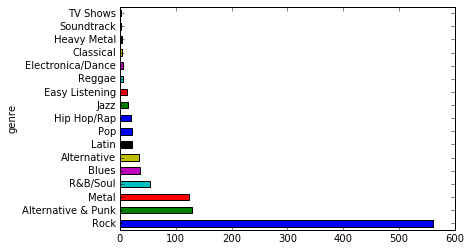

In [4]:
genre_sales_usa = run_query(album_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)
genre_sales_usa["tracks_sold"].plot.barh()
plt.show()

Buy "Red Tone", "Slim Jim Bites",

In [5]:
sale_by_representetive = '''
with purchase_by_customer as
    (
    SELECT
        c.customer_id, c.support_rep_id, sum(i.total) total
        from invoice i
        inner join customer c on c.customer_id = i.customer_id
        group by 1
    )

select
    e.first_name || " " || e.last_name employee_name,
    e.hire_date,
    sum(pc.total) total_sale_by_employee
    from purchase_by_customer pc
    inner join employee e on e.employee_id = pc.support_rep_id
    group by 1
    order by 3 desc
'''

run_query(sale_by_representetive)

,employee_name,hire_date,total_sale_by_employee
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


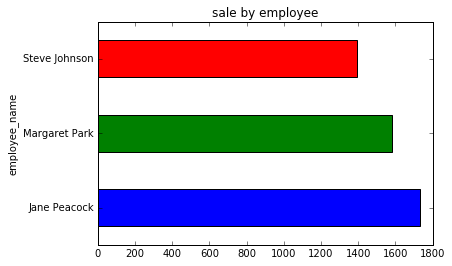

In [6]:
employee_sale = run_query(sale_by_representetive)
employee_sale.set_index("employee_name", drop=True, inplace=True)
employee_sale["total_sale_by_employee"].plot.barh(title='sale by employee')
plt.show()

In [7]:
sales_country = '''
with purchase_country as
    (
    Select
        CASE
            WHEN (
                SELECT
                    count(*)
                    from customer
                    where country = c.country
                    ) = 1 THEN "Other"
            ELSE c.country
        END as country,
        c.customer_id,
        i.invoice_id,
        i.total
        from invoice i
        inner join customer c on c.customer_id = i.customer_id
    )

SELECT
    country,
    customer_count,
    total_sale,
    average_value_customer,
    average_order_value
FROM
    (SELECT
        country,
        count(distinct customer_id) customer_count,
        sum(total) total_sale,
        sum(total) / count(distinct customer_id) average_value_customer,
        sum(total) / count(invoice_id) average_order_value,
        CASE
            WHEN
                country = "Other" THEN 1
            ELSE 0
        END as sort
        from purchase_country
        group by 1
        order by sort asc, total_sale desc)

'''
country_statistics = run_query(sales_country)
country_statistics

,country,customer_count,total_sale,average_value_customer,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


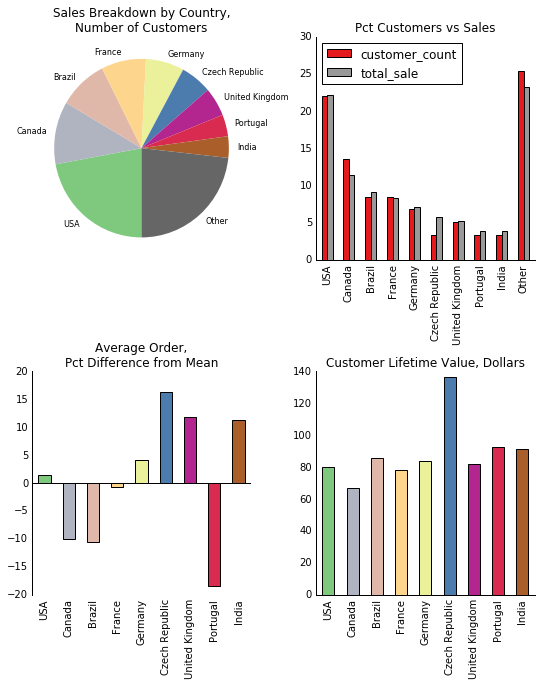

In [8]:
country_metrics = run_query(sales_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sale"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customer_count","total_sale"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["average_value_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

In [9]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
